In [329]:
import numpy as np 
import os 
import cv2 
import matplotlib.pyplot as plt 
import time
from scipy import ndimage
from time import time

profile = {
    'gray': 0,
    'guas': 0,
    'sobel': 0,
    'suppress': 0,
    'thres':0,
    'hyst':0,
}

In [330]:
# Replica of the functions used in hardware 

def gausian_filters(img):
    kernel = np.array([[1,4,7,4,1],[4,16,26,16,4],[7,26,41,26,7],[4,16,26,16,4],[1,4,7,4,1]], np.float64)
    kernel = kernel / 273;
    blur = ndimage.filters.convolve(img[:,:,0], kernel)
    blur = blur[:,:,np.newaxis]
    blur = np.concatenate([blur,blur,blur], -1)
    return blur

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float64)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float64)
    Ix = ndimage.filters.convolve(np.float32(img[:,:,0]), Kx)
    Iy = ndimage.filters.convolve(np.float32(img[:,:,0]), Ky)
    
    G = np.sqrt( (Ix * Ix) + (Iy * Iy))
    G = G / G.max() * 255  
    G = G.astype(int)
    G = G[:,:,np.newaxis]
    G = np.concatenate([G,G,G], -1)
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

def non_max_suppression(img, D):
    img = img[:,:,0]
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    Z = Z[:,:,np.newaxis]
    Z = np.concatenate([Z,Z,Z], -1)
    return Z



def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    img = img[:,:,0]
    highThreshold = 255 * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    res = res[:,:,np.newaxis]
    res = np.concatenate([res,res,res], -1)
    
    return (res, weak, strong)


def hysteresis(img, weak, strong=255):
    img = img[:,:,0]
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    img = img[:,:,np.newaxis]
    img = np.concatenate([img,img,img], -1)
    return img

In [331]:
# conversion ofimage to grayscale 
img = cv2.imread('parrot.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# plotting the RGB image

# plt.imshow(img)
# plt.show()

In [332]:
start = time()
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = gray[:,:,np.newaxis]
gray = np.concatenate([gray,gray,gray], -1)
end = time()
profile['gray']= (end - start) * 1000


# plotting the GRAYscale image

# plt.figure(figsize = (100,100))
# plt.imshow(gray)
# plt.show()

In [333]:
start = time()
guas = gausian_filters(img)
end = time()
profile['guas']= (end - start) * 1000


# plotting guassian 

# plt.figure(figsize = (100,100))
# plt.imshow(guas)
# plt.show()

# testing with CV2 guassian

# guas = cv2.GaussianBlur(gray, (5, 5), 1) 
# plt.figure(figsize = (100,100))
# plt.imshow(guas)
# plt.show()

In [334]:
start = time()
sobel, theta = sobel_filters(guas)
end = time()
profile['sobel']= (end - start) * 1000

# plotting 

# plt.figure(figsize = (100,100))
# plt.imshow(sobel)
# plt.show()

# testing with CV2 Sobel

# gx = cv2.Sobel(np.float32(guas), cv2.CV_64F, 1, 0, 3) 
# gy = cv2.Sobel(np.float32(guas), cv2.CV_64F, 0, 1, 3) 
      
# # Conversion of Cartesian coordinates to polar  
# mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 

# sobel = mag/mag.max() * 255
# sobel = sobel.astype(int)
# plt.imshow(sobel)
# plt.show()

In [335]:
start = time()
suppress = non_max_suppression(sobel, theta)
end = time()
profile['suppress']= (end - start) * 1000


# plotting the image after suppression

# plt.figure(figsize = (100,100))
# plt.imshow(suppress)
# plt.show()

In [336]:
start = time()
thres, weak, strong = threshold(suppress)
end = time()
profile['thres']= (end - start) * 1000

# plotting the image after dual thresholding 

# plt.figure(figsize = (100,100))
# plt.imshow(thres)
# plt.show()

In [337]:
start = time()
hyst = hysteresis(thres,  weak, strong)
end = time()
profile['hyst']= (end - start) * 1000

# plotting the image after hystersis

# plt.figure(figsize = (100,100))
# plt.imshow(hyst)
# plt.show()

In [338]:
print(profile.values())

dict_values([6.381988525390625, 52.964210510253906, 64.88442420959473, 7415.509223937988, 22.92466163635254, 645.2717781066895])


<BarContainer object of 6 artists>

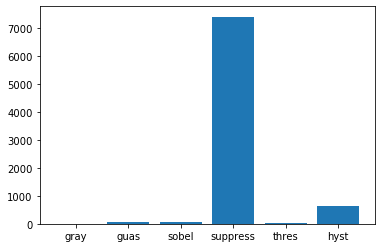

In [339]:
plt.bar(profile.keys(),profile.values())